In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

In [2]:
release_zone = "test_4000"
number_particles = 100000
start_year = 2009
start_month = 3
start_day = 1
runtime_in_days = 42

In [3]:
plt.rcParams.update({'font.size': 14})

In [4]:
#SIGMA=xr.open_dataset('../data/config/ROMS/sigma2depth_parent.nc')
INALT_mask=xr.open_dataset('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
SIGMA=xr.open_dataset('../data/config/ROMS/sigma2depth_parent.nc')
SIGMA_child=xr.open_dataset('../data/config/ROMS/sigma2depth_child.nc')

In [5]:
#Calculate bottom topography in INALT
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0)})
topo_INALT = topo_INALT.assign_coords({"lat": INALT_mask.gphit.isel(t=0,x=0)})
topo_INALT = topo_INALT.swap_dims({'x': 'lon'})
topo_INALT = topo_INALT.swap_dims({'y': 'lat'})

In [6]:
#Bottom topography in both ROMS
topo_ROMS = SIGMA['h']
topo_ROMS = topo_ROMS.rename({'lat_rho': 'lat','lon_rho': 'lon'})
topo_ROMS_child = SIGMA_child['h']
topo_ROMS_child = topo_ROMS_child.rename({'lat_rho': 'lat','lon_rho': 'lon'})

In [7]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter=",")
    df = df.set_index("release_zone")
    df.index = df.index.str.lower().str.replace(' ', '-').str.replace("'", '-')
    return df

In [8]:
release_locations = load_release_locations(release_locations_file = "../data/config/test_stations.csv")
bathymodiolus_lat, bathymodiolus_lon, release_depth = release_locations.loc[release_zone]

bathymodiolus_lat, bathymodiolus_lon, release_depth

(-23.25, 8.25, 4000.0)

In [9]:
#Depths of levels in INALT and ROMS
INALT_levels = INALT_mask.gdept_0
INALT_levels = INALT_levels.isel(y=0,t=0,x=0)

ROMS_levels = SIGMA.hs.where(SIGMA.hs<7000)
ROMS_levels = ROMS_levels.isel(lat_rho=128).sel(lon_rho=slice(7.559,8.858,None))

ROMS_child_levels = SIGMA_child.hs.where(SIGMA_child.hs<7000)
ROMS_child_levels = ROMS_child_levels.isel(lat_rho=140).sel(lon_rho=slice(7.559,8.858,None))

In [10]:
SIGMA.hs.where(SIGMA.hs<7000).max()

<xarray.DataArray 'hs' ()>
array(4843.41601562)

In [11]:
#Ewing Seamount Profile along latitude where the tip if the seamount is located
topo_INALT_bar=topo_INALT.isel(lat=295).sel( #-23.24
               lon=slice(7.559,
                         8.858,None))
topo_INALT_bar=-(topo_INALT_bar-INALT_levels.max()) #reverse so that bar plot works

topo_ROMS_bar=topo_ROMS.isel(lat=128).sel( #-23.24
             lon=slice(7.559,
                         8.858,None))
topo_ROMS_bar=-(topo_ROMS_bar-ROMS_levels.max())#SIGMA.hs.where(SIGMA.hs<7000).max())

topo_ROMS_child_bar=topo_ROMS_child.isel(lat=140).sel( #-23.24
               lon=slice(7.559,
                         8.858,None))
topo_ROMS_child_bar=-(topo_ROMS_child_bar-ROMS_child_levels.max())#SIGMA_child.hs.where(SIGMA_child.hs<7000).max())

In [12]:
topo_INALT.sel(lon=slice(7.5,9),lat=slice(-24,-23)).where(
    topo_INALT.sel(lon=slice(7.5,9),lat=slice(-24,-23))==topo_INALT.sel(lon=slice(7.5,9),lat=slice(-24,-23)).min(),drop=True)

<xarray.DataArray (lat: 1, lon: 1)>
array([[874.94332713]])
Coordinates:
  * lon      (lon) float32 8.3
  * lat      (lat) float32 -23.19

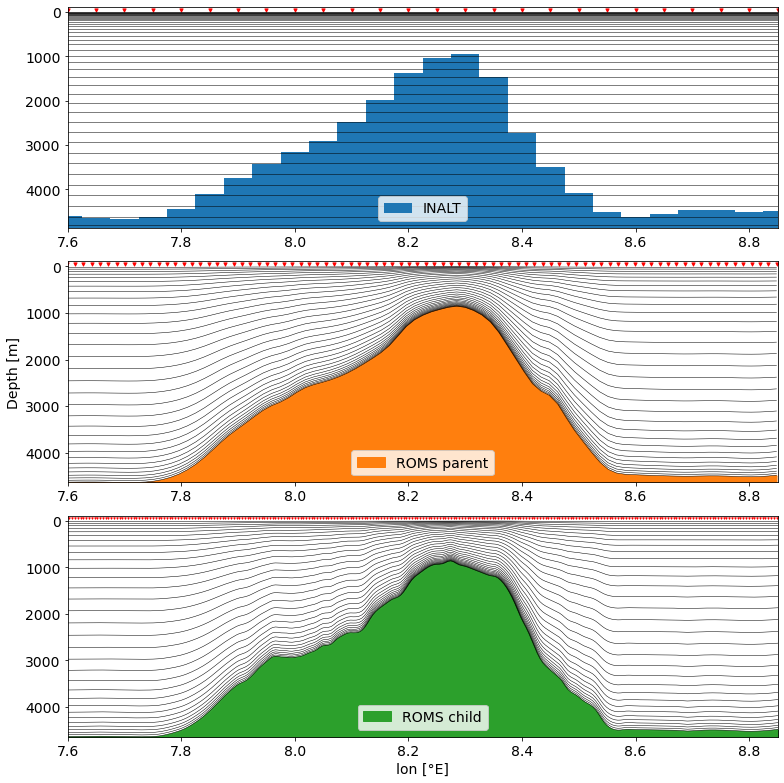

In [37]:
#Profile in INALT
plt.figure(figsize=(11,11))
plt.subplot(3,1,1)
plt.bar(np.linspace(7.6,8.85,26),topo_INALT_bar,width=0.05,label='INALT')
plt.yticks(np.linspace(INALT_levels.max()-4000,INALT_levels.max(),5),[int(i) for i in np.linspace(4000,0,5)],fontsize=14)
plt.scatter(topo_INALT_bar.lon,np.linspace(INALT_levels.max()+50,
                                                INALT_levels.max()+50,len(topo_INALT_bar.lon)),
           color='red',s=10,marker='v')
plt.xlim([7.6,8.85])
plt.ylim([1000,INALT_levels.max()+110])
plt.xticks([7.6,7.8,8,8.2,8.4,8.6,8.8],fontsize=14)
plt.legend(loc="lower center",fontsize=14)
for i in INALT_levels:
    plt.plot(np.linspace(7.6,8.85,2),[-(i-INALT_levels.max()),-(i-INALT_levels.max())],color='black',linewidth='0.5')

plt.subplot(3,1,2)    
plt.plot(np.linspace(7.559,8.848,88),topo_ROMS_bar,color='tab:orange')
plt.fill_between(np.linspace(7.559,8.848,88), 0, topo_ROMS_bar,color='tab:orange',label='ROMS parent')
plt.legend(loc="lower center",fontsize=14)
plt.scatter(topo_ROMS_bar.lon,np.linspace(ROMS_levels.max()+50,
                                                ROMS_levels.max()+50,len(topo_ROMS_bar.lon)),
           color='red',s=10,marker='v')
plt.xlim([7.6,8.85])
plt.xticks([7.6,7.8,8,8.2,8.4,8.6,8.8],fontsize=14)
plt.ylim([0,ROMS_levels.max()+110])
plt.ylabel('Depth [m]',fontsize=14)
plt.yticks(np.linspace(ROMS_levels.max()-4000,ROMS_levels.max(),5),[int(i) for i in np.linspace(4000,0,5)],fontsize=14)
for i in [int(j) for j in np.linspace(0,len(ROMS_levels.slev)-1,len(ROMS_levels.slev))]:
    plt.plot(np.linspace(7.559,8.848,88),-(ROMS_levels.isel(slev=i)-ROMS_levels.max()),color='black',linewidth='0.5')
    
plt.subplot(3,1,3)   
plt.plot(np.linspace(7.559,8.853,265),topo_ROMS_child_bar,color='tab:green')
plt.fill_between(np.linspace(7.559,8.853,265), 0, topo_ROMS_child_bar,color='tab:green',label='ROMS child')
plt.scatter(topo_ROMS_child_bar.lon,np.linspace(ROMS_child_levels.max()+50,
                                                ROMS_child_levels.max()+50,len(topo_ROMS_child_bar.lon)),
           color='red',s=2,marker='v')
plt.xlim([7.6,8.85])
plt.xticks([7.6,7.8,8,8.2,8.4,8.6,8.8],fontsize=14)
plt.xlabel('lon [°E]',fontsize=14)
plt.ylim([0,ROMS_child_levels.max()+110])
plt.legend(loc="lower center",fontsize=14)
plt.yticks(np.linspace(ROMS_child_levels.max()-4000,ROMS_child_levels.max(),5),[int(i) for i in np.linspace(4000,0,5)],fontsize=14)
for i in [int(j) for j in np.linspace(0,len(ROMS_child_levels.slev)-1,len(ROMS_child_levels.slev))]:
    plt.plot(np.linspace(7.559,8.853,265),-(ROMS_child_levels.isel(slev=i)-ROMS_child_levels.max()),color='black',linewidth='0.5')
plt.tight_layout();

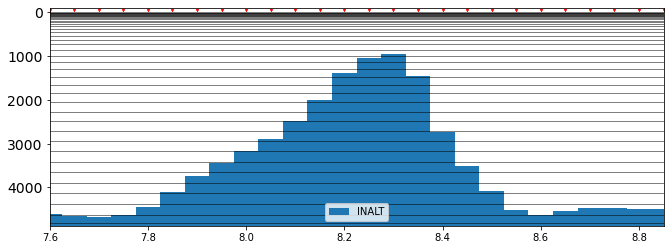

In [14]:
#Profile in INALT
plt.figure(figsize=(11,4))
plt.bar(np.linspace(7.6,8.85,26),topo_INALT_bar,width=0.05,label='INALT')
plt.yticks(np.linspace(INALT_levels.max()-4000,INALT_levels.max(),5),[int(i) for i in np.linspace(4000,0,5)],fontsize=14)
plt.scatter(topo_INALT_bar.lon,np.linspace(INALT_levels.max()+50,
                                                INALT_levels.max()+50,len(topo_INALT_bar.lon)),
           color='red',s=4,marker='v')
plt.xlim([7.6,8.85])
plt.ylim([1000,INALT_levels.max()+90])
plt.legend(loc="lower center")
for i in INALT_levels:
    plt.plot(np.linspace(7.6,8.85,2),[-(i-INALT_levels.max()),-(i-INALT_levels.max())],color='black',linewidth='0.5');

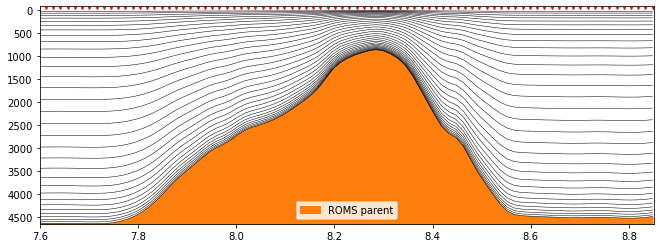

In [110]:
#Profile in ROMS parent
plt.figure(figsize=(11,4))
plt.plot(np.linspace(7.559,8.848,88),topo_ROMS_bar,color='tab:orange')
plt.fill_between(np.linspace(7.559,8.848,88), 0, topo_ROMS_bar,color='tab:orange',label='ROMS parent')
plt.legend(loc="lower center")
plt.scatter(topo_ROMS_bar.lon,np.linspace(ROMS_levels.max()+50,
                                                ROMS_levels.max()+50,len(topo_ROMS_bar.lon)),
           color='red',s=4,marker='v')
plt.xlim([7.6,8.85])
plt.ylim([0,ROMS_levels.max()+90])
plt.yticks(np.linspace(ROMS_levels.max()-4500,ROMS_levels.max(),10),[int(i) for i in np.linspace(4500,0,10)])
for i in [int(j) for j in np.linspace(0,len(ROMS_levels.slev)-1,len(ROMS_levels.slev))]:
    plt.plot(np.linspace(7.559,8.848,88),-(ROMS_levels.isel(slev=i)-ROMS_levels.max()),color='black',linewidth='0.5');

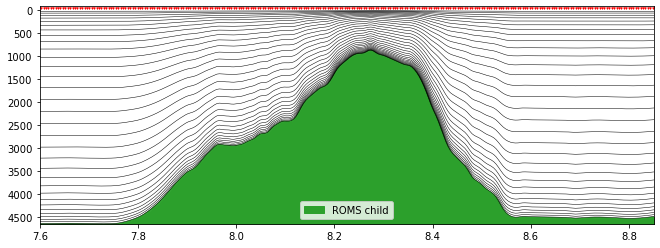

In [116]:
#Profile in ROMS child
plt.figure(figsize=(11,4))
plt.plot(np.linspace(7.559,8.853,265),topo_ROMS_child_bar,color='tab:green')
plt.fill_between(np.linspace(7.559,8.853,265), 0, topo_ROMS_child_bar,color='tab:green',label='ROMS child')
plt.scatter(topo_ROMS_child_bar.lon,np.linspace(ROMS_child_levels.max()+50,
                                                ROMS_child_levels.max()+50,len(topo_ROMS_child_bar.lon)),
           color='red',s=2,marker='v')
plt.xlim([7.6,8.85])
plt.ylim([0,ROMS_child_levels.max()+90])
plt.legend(loc="lower center")
plt.yticks(np.linspace(ROMS_child_levels.max()-4500,ROMS_child_levels.max(),10),[int(i) for i in np.linspace(4500,0,10)])
for i in [int(j) for j in np.linspace(0,len(ROMS_child_levels.slev)-1,len(ROMS_child_levels.slev))]:
    plt.plot(np.linspace(7.559,8.853,265),-(ROMS_child_levels.isel(slev=i)-ROMS_child_levels.max()),color='black',linewidth='0.5');

In [47]:
topo_ROMS_child_bar.lon

<xarray.DataArray 'lon' (lon: 265)>
array([7.55902 , 7.563921, 7.568823, ..., 8.843333, 8.848235, 8.853137],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 7.559 7.564 7.569 7.574 ... 8.838 8.843 8.848 8.853
    lat      float32 -23.24
    lat_rho  float32 -23.24
Attributes:
    long_name:      longitude coordinate at rho points
    standard_name:  longitude
    units:          degrees_east

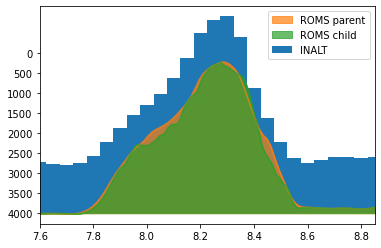

In [34]:
plt.bar(np.linspace(7.6,8.85,26),topo_INALT_bar,width=0.05,label='INALT')
plt.plot(np.linspace(7.559,8.848,88),topo_ROMS_bar,color='tab:orange',alpha=0.7)
plt.fill_between(np.linspace(7.559,8.848,88), 0, topo_ROMS_bar,color='tab:orange',label='ROMS parent',alpha=0.7)
plt.plot(np.linspace(7.559,8.853,265),topo_ROMS_child_bar,color='tab:green',alpha=0.7)
plt.fill_between(np.linspace(7.559,8.853,265), 0, topo_ROMS_child_bar,color='tab:green',label='ROMS child',alpha=0.7)
plt.xlim([7.6,8.85])
plt.legend()
plt.yticks(np.linspace(0,4000,9),[int(i) for i in np.linspace(4000,0,9)]);

In [39]:
topo_INALT_2325=topo_INALT.isel(lat=295).sel( #-23.24
               lon=slice(7.559,
                         8.858,None))
topo_INALT_2325=-(topo_INALT_2325-INALT_levels.max())

topo_ROMS_2325=topo_ROMS.isel(lat=128).sel( #-23.24
             lon=slice(7.559,
                         8.858,None))
topo_ROMS_2325=-(topo_ROMS_2325-ROMS_levels.max())

topo_ROMS_child_2325=topo_ROMS_child.isel(lat=140).sel( #-23.24
               lon=slice(7.559,
                         8.858,None))
topo_ROMS_child_2325=-(topo_ROMS_child_2325-ROMS_child_levels.max())

topo_ROMS_child_test1=topo_ROMS_child.isel(lat=156).sel( #-23.25
               lon=slice(7.559,
                         8.858,None))
topo_ROMS_child_test1=-(topo_ROMS_child_test1-topo_ROMS_child_test1.max())

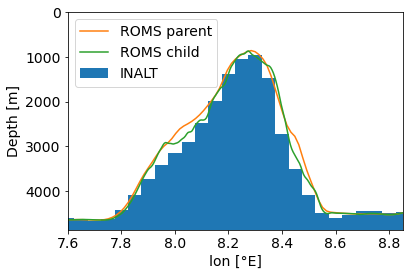

In [41]:
plt.bar(np.linspace(7.6,8.85,26),topo_INALT_2325,width=0.05,label='INALT')
plt.plot(np.linspace(7.559,8.848,88),topo_ROMS_2325+INALT_levels.max()-ROMS_levels.max(),label='ROMS parent',color='tab:orange')
plt.plot(np.linspace(7.559,8.853,265),topo_ROMS_child_2325+INALT_levels.max()-ROMS_child_levels.max(),label='ROMS child',color='tab:green')
plt.yticks(np.linspace(INALT_levels.max()-4000,INALT_levels.max(),5),[int(i) for i in np.linspace(4000,0,5)],fontsize=14)
plt.xlim([7.6,8.85])
plt.ylim([1000,INALT_levels.max()])
plt.xticks([7.6,7.8,8,8.2,8.4,8.6,8.8],fontsize=14)
plt.legend(fontsize=14)
plt.xlabel('lon [°E]',fontsize=14)
plt.ylabel('Depth [m]',fontsize=14);

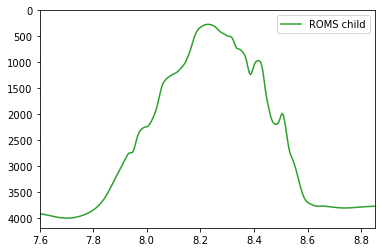

In [17]:
plt.plot(np.linspace(7.559,8.853,265),topo_ROMS_child_test1,color='tab:green',label='ROMS child')
plt.xlim([7.6,8.85])
plt.legend()
plt.yticks(np.linspace(0,4000,9),[int(i) for i in np.linspace(4000,0,9)]);